# Targeted Training Notebook
A practical guide to the targeted training process. 

**Author:** Kalyan Dutia (kalyan.dutia@ibm.com)

Here we assume that you **already have your intents downloaded, in the `data/workspace_training` folder.** If you don't, you can manually download them or use the tool contained in the exploratory analysis notebook.

In [ ]:
# installs
!pip install watson_developer_cloud==2.0.1
!pip install itables

In [1]:
# external imports
import os
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
from itables import show
import logging
import time
import matplotlib.pyplot as plt

# internal imports
import config
from cli_tools.get_intent_intersections import intent_intersections
from conversation_test.kfoldtest import kfoldtest

# config
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.set_option('display.max_colwidth', -1)

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3.connectionpool").setLevel(logging.WARNING)


<IPython.core.display.Javascript object>

## Load a skill
If you can't see your skill here, check the `data/workspace_training` folder.

In [28]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d)
        display_sample(d, 10)

def display_sample(d, samplesize):
    if samplesize != None:
        display(Markdown("**<span style='color:blue'>{}</span>** skill selected. Training data sample:".format(d.value)))
    training_file = training_files[d.index]

    train_df = pd.read_csv(os.path.join(config.training_dir, training_file), names=['utterance', 'intent'])
    if (len(train_df) > 0) & (samplesize != None):
        display(train_df.sample(samplesize))
    elif samplesize:
        display(Markdown("<span style='color:red'>No intent training data exists for this workspace</span>"))
    
    return train_df

training_files = [file for file in os.listdir(config.training_dir) if file.endswith('.csv')]
d = widgets.Dropdown(options=[item[0:len(item)-14] for item in training_files])
d.observe(onchange)

display(d)
train_df = display_sample(d, 10)
intents = train_df['intent'].unique()

Dropdown(options=('puppy', 'Customer Care Sample Skill'), value='puppy')

**<span style='color:blue'>puppy</span>** skill selected. Training data sample:

,utterance,intent
31,at what age do I not need to get my pooch jabs,DOG_VACCINATIONS
120,can I mix my dogs food,DOG_FOOD
34,do you need to have allthe vaccinations recommended,DOG_VACCINATIONS
78,Has the dog been ill before,DOG_HEALTH
107,whre can I check if my dogs parentals have bred before,DOG_PARENTS_INFORMATION
77,Can you tell me if the puppy is diseased,DOG_HEALTH
61,do dogs get depression,DOG_HEALTH
3,"hello, what should I do to buy a puppy?",PURCHASE_DOG
6,I'm looking to buy a dog,PURCHASE_DOG
14,Can I get a puppy?,PURCHASE_DOG


We also need the details of the workspace and instance in Watson:

In [3]:
# first set workspace given selection above
train_df = display_sample(d, None)

# INSTANCE. Use one of apikey or username & password
apikey = "5XuD4BoYqV0Lx5PUltqzVnDue1MzCTgGcld8uCtPsNR_"
#username = 
#password = 
url = "https://gateway.watsonplatform.net/assistant/api/"

# WORKSPACE 
workspace_id = "e6b17f68-9a81-4ac6-ae18-231717a47d3a"
threshold = 0.4

# TEST PARAMS
nfolds = 3

## Run K-Fold test
In order to work out which intents to target, we first run a K-Fold test on our workspace.
You can also directly run one using the module in the `conversation_test` folder.

The kfold test returns:
- `results_kfold`: the classification per utterances
- `classification_report`: f1 score, accuracy, precision and recall per intent, as well as averages

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

kfold = kfoldtest(apikey=apikey, url=url, n_folds=nfolds, threshold=threshold)
kfold.intent_df_from_df(train_df)
results_kfold, classification_report = kfold.full_run_kfold_from_df(train_df)

[2019-07-30 13:14:52,023] INFO (kfoldtest): You have space to perform the k-fold test
[2019-07-30 13:14:52,028] DEBUG (kfoldtest): fold num 1: train set: 89, test set: 47
[2019-07-30 13:14:52,029] DEBUG (kfoldtest): fold num 2: train set: 91, test set: 45
[2019-07-30 13:14:52,030] DEBUG (kfoldtest): fold num 3: train set: 92, test set: 44
[2019-07-30 13:14:52,033] INFO (kfoldtest): Creating kfold workspaces..
[2019-07-30 13:14:55,961] INFO (kfoldtest): Checking workspaces..
[2019-07-30 13:15:19,124] INFO (kfoldtest): Checking workspaces..
[2019-07-30 13:15:20,195] DEBUG (kfoldtest): Workspace 1 available
[2019-07-30 13:15:22,142] DEBUG (kfoldtest): Workspace 3 available
[2019-07-30 13:15:42,148] INFO (kfoldtest): Checking workspaces..
[2019-07-30 13:15:43,098] DEBUG (kfoldtest): Workspace 1 available
[2019-07-30 13:15:44,142] DEBUG (kfoldtest): Workspace 2 available
[2019-07-30 13:15:45,281] DEBUG (kfoldtest): Workspace 3 available
[2019-07-30 13:16:05,288] INFO (kfoldtest): Running te

### View worst performing intents
We'll first choose a metric, then create a CSV showing the worst performing intents which can be used for annotation throughout this process.

In [29]:
display(Markdown("Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>" 

"\n \n If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide."

"\n \n**Preferred metric:**"))
        
d_m = widgets.Dropdown(options=['precision', 'recall', 'accuracy', 'F1'])
display(d_m)

Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>
 
 If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide.
 
**Preferred metric:**

Dropdown(options=('precision', 'recall', 'accuracy', 'F1'), value='precision')

In [30]:
cl_rep_export = classification_report.loc[intents, :].sort_values(d_m.value, ascending=True)
cl_rep_export = cl_rep_export.drop(columns='set size')

intent_sizes = train_df.groupby('intent').count()
cl_rep_export['train_size'] = intent_sizes

cl_rep_export['comment'] = ""
cl_rep_export['action'] = ""

timestr = time.strftime("%Y%m%d-%H%M")
filename = d.value + '_kfold_results_' + timestr + '.csv'
output_path = os.path.join(config.output_folder, filename)
cl_rep_export.to_csv(output_path)

display(Markdown("We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation."))
display(Markdown("These results have been exported to <span style='color:blue'>{}</span> for annotation throughout the targeted training process.".format(output_path)))
display(cl_rep_export)



We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation.

These results have been exported to <span style='color:blue'>/Users/kalyan/Documents/practice-cog/intent_training_tools/results/puppy_kfold_results_20190731-1010.csv</span> for annotation throughout the targeted training process.

confusion,threshold,accuracy,precision,recall,F1,train_size,comment,action
DOG_HEALTH,0.4,0.718750,0.733333,0.956522,0.830189,29,,
PURCHASE_DOG,0.4,0.757576,0.827586,0.888889,0.857143,28,,
DOG_PARENTS_INFORMATION,0.4,0.869565,0.869565,1.000000,0.930233,24,,
DOG_VACCINATIONS,0.4,0.857143,0.900000,0.947368,0.923077,28,,
DOG_FOOD,0.4,0.925926,0.960000,0.960000,0.960000,27,,


We can also view a plot of these.

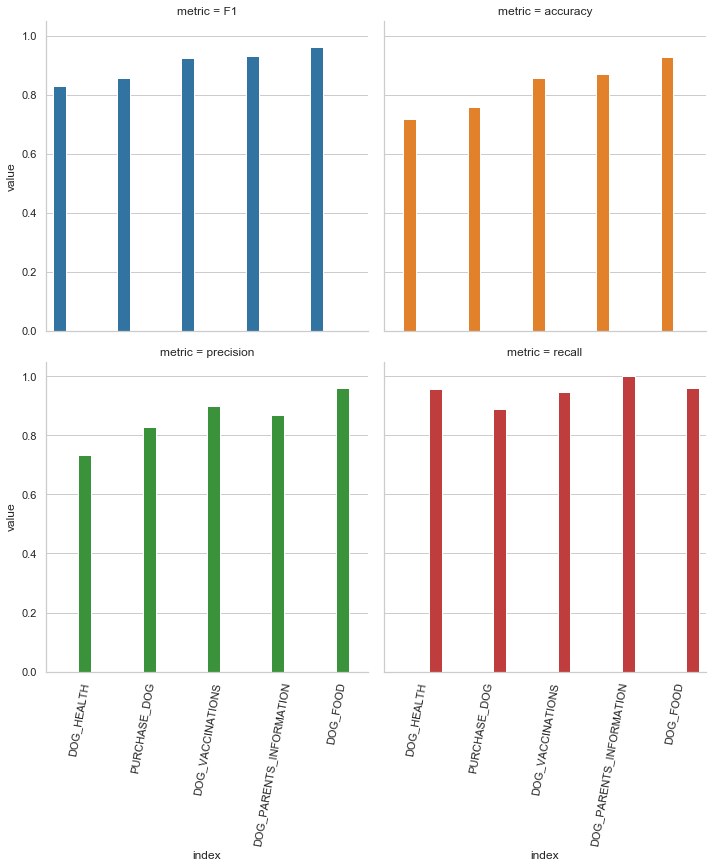

In [16]:
display(Markdown("We can also view a plot of these."))
melt_df = cl_rep_export.reset_index().melt(id_vars=['index'], value_vars=['F1', 'accuracy', 'precision', 'recall']).rename(columns={'confusion': 'metric'})
ax = sns.catplot(data=melt_df, col_wrap=2, x='index', y='value', col='metric', kind='bar', hue="metric")
[plt.setp(ax.get_xticklabels(), rotation=80) for ax in ax.axes.flat];

## Assess Root Cause
The next stage is to write some comments and actions for the training that is needed. To do this we'll use the tools in this section.

### More training?
A common sign that an intent needs more training is that it has **low recall**: it is commonly not matching intents with enough confidence to provide a response. To test for this we can plot recall against training set size for our intents. 

You should investigate any intents which fall on the bottom left hand size of this plot as candidates for getting more training.

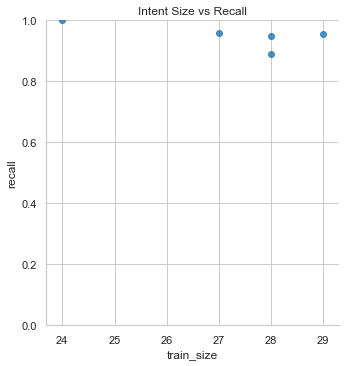

In [31]:
ax = sns.lmplot(data=cl_rep_export, x='train_size', y='recall', fit_reg=False)
ax.axes[0,0].set_title('Intent Size vs Recall')
ax.axes[0,0].set_ylim(0,1);

### Intent Overlaps
Here we'll use tools to find overlapping phrases between intents that may be causing confusion between them. 

Change the parameters in the next cell to choose the length of the ngrams being searched for, and whether to remove stopwords.

In [32]:
ngram_list = [4,5] 
stopwords = 'none' # stopwords_in can be none, nltk, or config

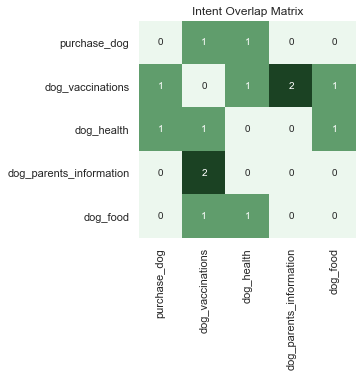

In [33]:
ii = intent_intersections(ngram_list, stopwords_in=stopwords, intent_col='intent')
ii.import_training_df(train_df)
intersection_df, intersection_size_df = ii.calculate_ngram_intersections()

intersection_size_df = intersection_size_df.fillna(0)
heatmap_colors = sns.cubehelix_palette(8, start=2, rot=0, dark=0.2, light=.95, reverse=False)
ax = sns.heatmap(intersection_size_df, annot=True, cmap=heatmap_colors, cbar=False, square=True)
ax.set_title('Intent Overlap Matrix');

Next, we can look into specific overlaps:

In [34]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d01)
        display(d02)
        display_intent_overlap(d01.value, d02.value)

def display_intent_overlap(intent1, intent2):
    if d01.value != d02.value:
        ngrams_per_intent_df, ngram_freq_df = ii.get_ngrams_per_intent()
        overlap_df = ii.get_intersection_freqs([intent1, intent2], ngram_freq_df)
        overlap_df = overlap_df.sort_values([intent1, intent2], ascending=False)
        display(overlap_df)
    else:
        display(Markdown("Intents chosen can't be the same"))

d01 = widgets.Dropdown(options=train_df['intent'].unique())
d02 = widgets.Dropdown(options=train_df['intent'].unique())

d01.observe(onchange)
d02.observe(onchange)

display(d01)
display(d02)
display_intent_overlap(d01.value, d02.value)

Dropdown(index=2, options=('purchase_dog', 'dog_vaccinations', 'dog_health', 'dog_parents_information', 'dog_f…

Dropdown(index=4, options=('purchase_dog', 'dog_vaccinations', 'dog_health', 'dog_parents_information', 'dog_f…

,dog_health,dog_food
i don't know what,1.0,1.0


In [22]:
display(Markdown("You can use the table below to search through training utterances."))
show(train_df[['utterance', 'intent']])

You can use the table below to search through training utterances.

utterance,intent


## Training

The process of 'training' will fall into one of three categories: resolving clashes, cleaning training data, or getting more training data. 

See the last section of the Training at Scale guide for tips on how to improve your training data.